In [20]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from tqdm import tqdm

import polars as pol

import matplotlib.ticker as ticker

import hvplot.pandas

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Data wrangling / cleaning

In [2]:
el_price_path = "Data/Elspotprices_small.csv"

data_frame = pd.read_csv(el_price_path, sep = ";") # our dataframe as header, thus True.

data_frame = data_frame.dropna()

data_frame.head(10)


,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2022-12-31 22:00,2022-12-31 23:00,DE,"-5,060000","-0,680000"
1,2022-12-31 22:00,2022-12-31 23:00,DK1,"35,990002","4,840000"
2,2022-12-31 22:00,2022-12-31 23:00,NO2,"892,260010","119,980003"
3,2022-12-31 22:00,2022-12-31 23:00,DK2,"35,990002","4,840000"
4,2022-12-31 22:00,2022-12-31 23:00,SE4,"35,990002","4,840000"
5,2022-12-31 22:00,2022-12-31 23:00,SE3,"35,990002","4,840000"
6,2022-12-31 22:00,2022-12-31 23:00,SYSTEM,"200,490005","26,959999"
7,2022-12-31 21:00,2022-12-31 22:00,SE3,"73,919998","9,940000"
8,2022-12-31 21:00,2022-12-31 22:00,SYSTEM,"206,149994","27,719999"
9,2022-12-31 21:00,2022-12-31 22:00,DK2,"73,919998","9,940000"


We convert the last 2 columns into floats.

In [3]:
data_frame[["SpotPriceDKK", "SpotPriceEUR"]] = data_frame[["SpotPriceDKK", "SpotPriceEUR"]].applymap(lambda x: x.replace(",", ".") if isinstance(x,str) else x)

data_frame.head(10)

data_frame["HourDK"] = pd.to_datetime(data_frame['HourDK'])

data_frame.insert(0, "YearDK", data_frame['HourDK'].dt.year)

data_frame.insert(1, "DateDK", data_frame['HourDK'].dt.date)

data_frame.insert(2, "TimeDK", data_frame['HourDK'].dt.time)

data_frame = data_frame.drop("HourUTC", axis = 1)


In [4]:
data_frame.head(10)

,YearDK,DateDK,TimeDK,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DE,-5.060000,-0.680000
1,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DK1,35.990002,4.840000
2,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,NO2,892.260010,119.980003
3,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DK2,35.990002,4.840000
4,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,SE4,35.990002,4.840000
5,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,SE3,35.990002,4.840000
6,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,SYSTEM,200.490005,26.959999
7,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,SE3,73.919998,9.940000
8,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,SYSTEM,206.149994,27.719999
9,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,DK2,73.919998,9.940000


In [5]:
#data_frame.set_index('HourDK', inplace=True)
#data_frame.sort_index(inplace=True)

In [6]:
data_frame.head(10)

,YearDK,DateDK,TimeDK,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DE,-5.060000,-0.680000
1,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DK1,35.990002,4.840000
2,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,NO2,892.260010,119.980003
3,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DK2,35.990002,4.840000
4,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,SE4,35.990002,4.840000
5,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,SE3,35.990002,4.840000
6,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,SYSTEM,200.490005,26.959999
7,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,SE3,73.919998,9.940000
8,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,SYSTEM,206.149994,27.719999
9,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,DK2,73.919998,9.940000


We'll focus on DK1, DK2 and "other" price areas

In [7]:
data_dk = data_frame[data_frame["PriceArea"].isin(["DK1", "DK2", "DK"])]

data_other = data_frame[~data_frame["PriceArea"].isin(["DK1", "DK2", "DK"])]

data_dk.head(10)

,YearDK,DateDK,TimeDK,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
1,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DK1,35.990002,4.840000
3,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DK2,35.990002,4.840000
9,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,DK2,73.919998,9.940000
11,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,DK1,73.919998,9.940000
14,2022,2022-12-31,21:00:00,2022-12-31 21:00:00,DK1,110.730003,14.890000
16,2022,2022-12-31,21:00:00,2022-12-31 21:00:00,DK2,110.730003,14.890000
23,2022,2022-12-31,20:00:00,2022-12-31 20:00:00,DK2,86.040001,11.570000
25,2022,2022-12-31,20:00:00,2022-12-31 20:00:00,DK1,301.190002,40.500000
28,2022,2022-12-31,19:00:00,2022-12-31 19:00:00,DK1,498.329987,67.010002
30,2022,2022-12-31,19:00:00,2022-12-31 19:00:00,DK2,112.150002,15.080000


In [8]:
data_dk_time_series = data_dk[["HourDK","SpotPriceDKK", "PriceArea"]]

data_dk_time_series = data_dk_time_series.astype({'SpotPriceDKK':'float'})

data_dk_time_series.head(10)

,HourDK,SpotPriceDKK,PriceArea
1,2022-12-31 23:00:00,35.990002,DK1
3,2022-12-31 23:00:00,35.990002,DK2
9,2022-12-31 22:00:00,73.919998,DK2
11,2022-12-31 22:00:00,73.919998,DK1
14,2022-12-31 21:00:00,110.730003,DK1
16,2022-12-31 21:00:00,110.730003,DK2
23,2022-12-31 20:00:00,86.040001,DK2
25,2022-12-31 20:00:00,301.190002,DK1
28,2022-12-31 19:00:00,498.329987,DK1
30,2022-12-31 19:00:00,112.150002,DK2


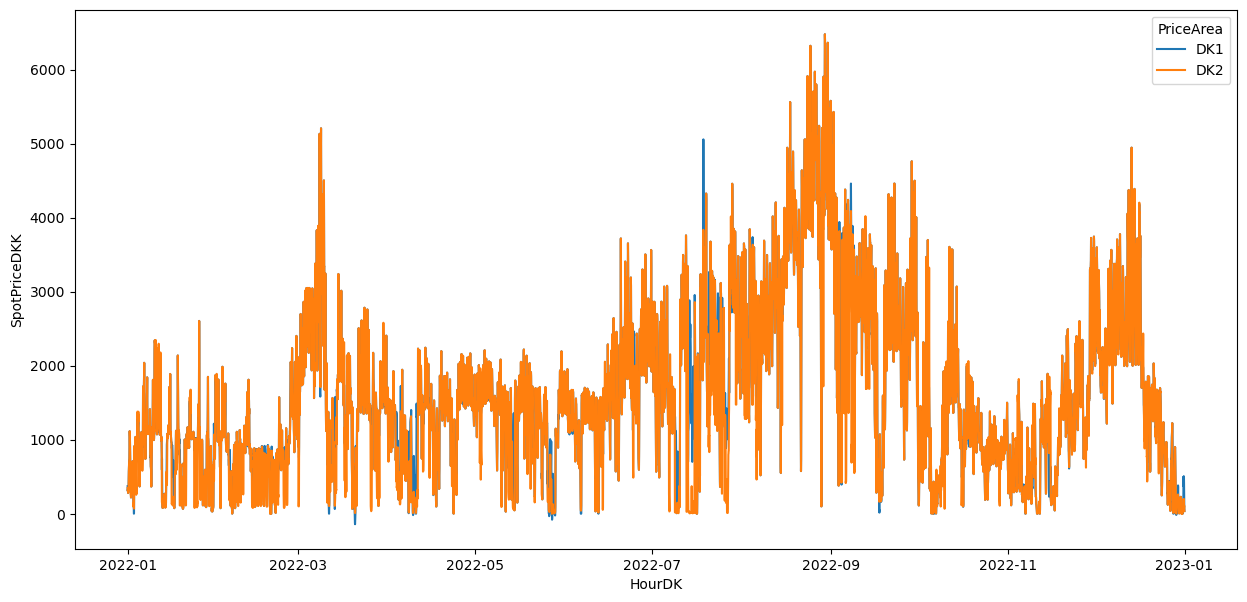

In [9]:
fig, ax = plt.subplots(figsize = (15, 7))

sns.lineplot(x = "HourDK", y = "SpotPriceDKK",
            hue = "PriceArea", data = data_dk_time_series)

plt.show()

The difference between DK1 and DK2 is not significant at all

We'll now try to predict the next value for DK1 and DK2 based on the previous observations, which can be done with the ARIMA (or any other extensions) model.

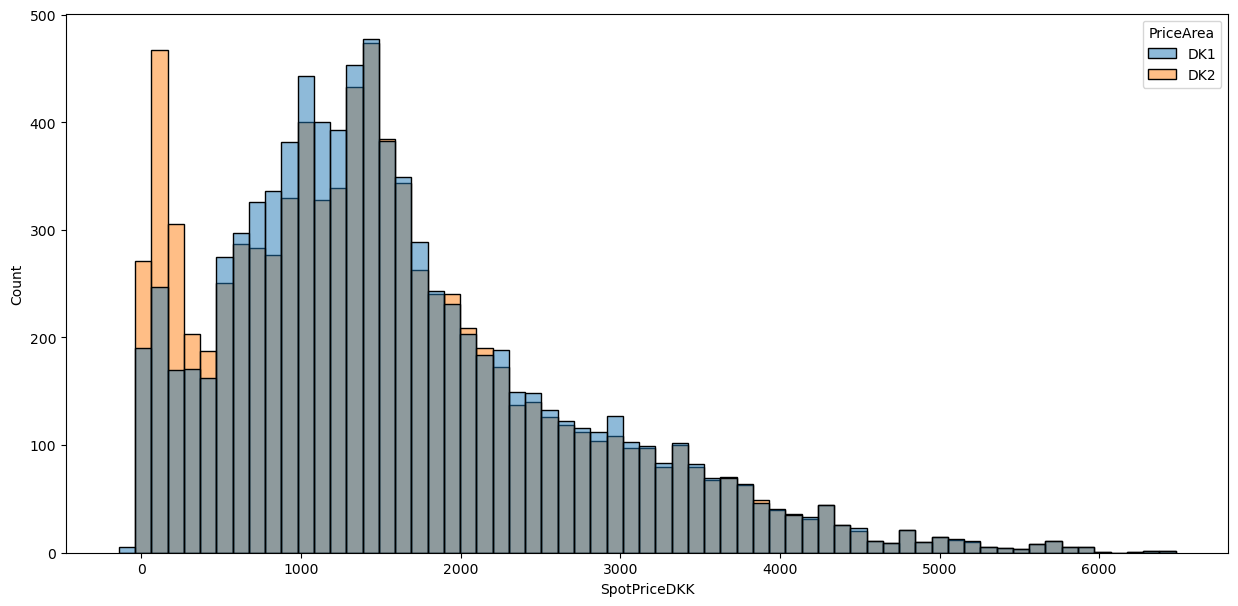

In [18]:
plt.subplots(figsize = (15, 7))

sns.histplot(data = data_dk_time_series, x = "SpotPriceDKK", hue = "PriceArea")

plt.show()

Because of the similarity, Prices from DK1 will be used

In [28]:
data_dk_time_series_dk1 = data_dk_time_series[data_dk_time_series["PriceArea"].isin(["DK1"])]

data_dk_time_series_dk1.head(10)

,HourDK,SpotPriceDKK,PriceArea
1,2022-12-31 23:00:00,35.990002,DK1
11,2022-12-31 22:00:00,73.919998,DK1
14,2022-12-31 21:00:00,110.730003,DK1
25,2022-12-31 20:00:00,301.190002,DK1
28,2022-12-31 19:00:00,498.329987,DK1
39,2022-12-31 18:00:00,506.440002,DK1
42,2022-12-31 17:00:00,499.820007,DK1
53,2022-12-31 16:00:00,371.390015,DK1
56,2022-12-31 15:00:00,499.079987,DK1
67,2022-12-31 14:00:00,126.349998,DK1


We'll start off by finding the order for our ARIMA

# PACF & ACF

In [29]:
data_dk_time_series_dk1 = data_dk_time_series_dk1.drop('PriceArea', axis=1)

data_dk_time_series_dk1.head(10)

,HourDK,SpotPriceDKK
1,2022-12-31 23:00:00,35.990002
11,2022-12-31 22:00:00,73.919998
14,2022-12-31 21:00:00,110.730003
25,2022-12-31 20:00:00,301.190002
28,2022-12-31 19:00:00,498.329987
39,2022-12-31 18:00:00,506.440002
42,2022-12-31 17:00:00,499.820007
53,2022-12-31 16:00:00,371.390015
56,2022-12-31 15:00:00,499.079987
67,2022-12-31 14:00:00,126.349998


In [35]:
data_dk_time_series_dk1.iloc[:,1]

1         35.990002
11        73.919998
14       110.730003
25       301.190002
28       498.329987
            ...    
61285    280.130005
61296    338.059998
61299    321.410004
61310    307.350006
61313    372.200012
Name: SpotPriceDKK, Length: 8760, dtype: float64

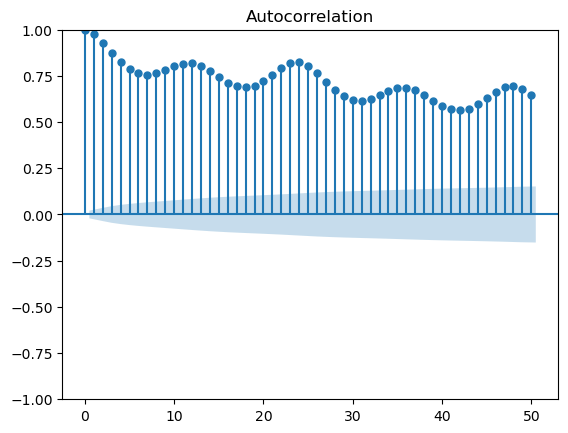

In [43]:
plot_acf(data_dk_time_series_dk1.iloc[:,1],lags = 50)
plt.show()

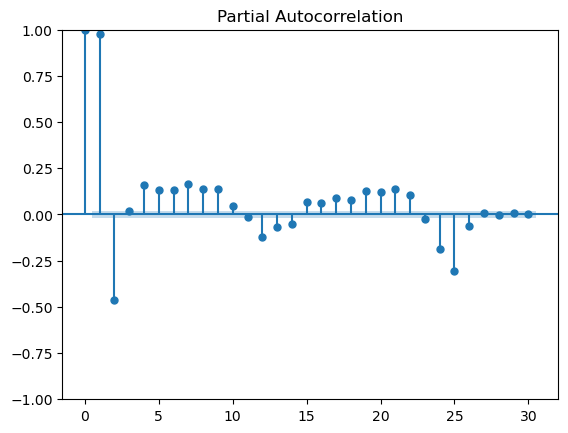

In [45]:
plot_pacf(data_dk_time_series_dk1.iloc[:,1], lags = 30)
plt.show()

Based on the results from above, we should start with an Autoregressive model with correlated lags (1,2,3 and 25)